# Research Project - Uncertainty Quantification
- **Author** : Amine Rannen-Triki
- **Date**: 15/06/2025
- Imperial College London - Department of Mathematics
- MS Machine Learning and Data Science (MLDS)
- Notebook 01 - Phase 1 - Validation

## 1. Introduction

### 1.1. Context of Uncertainty Quantification (UQ) in Machine Learning:
In many critical application with the use of deep learning models, from healthcare to nuclear energy, industry and autonomous driving, it is curcial that a model not only predict an output but also give information about its level of confidence of this output. In those domain, a machine learning model is usualy integrated within a wider multiple systems solution, and it is important that this model 'knows what it doesn't know' and give the information about its confidence on this output so the overall system could integrate this into the overall decision making.

### 1.2. Objective of this notebook:
This notebook presents the first experiments to test a specifically designed auxiliary model with a new proposed loss function to try to achieve the goal of knowing the level of confidence of a deep learning (DL) network.
The overall idea is based on a known method of augmenting a standard DL predictive model ($f$) with an auxiliary conviction model ($w$) and train both models simultaniously to estimate the level of confidence and reliability of the main predictive model. The research question could be summerised in the following :   



>> Can we find a specific DL architecture model including both a primary predictor ($f$) and an auxiliary conviction model ($w$), with a newly proposed conviction-wrighted loss function $L_{new}$ and train simultanesouly this model ($w+f$) so $w(x)$ learns the level of confidence between $[0,1]$ of each $f(x)$ prediction ?

### 1.3. Imports and functions used in the notbook


In [ ]:
# ==============================================================================
#                      IMPORTS AND CONFIGURATION
# ==============================================================================
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
# --- Custom Imports ---
from f_plots import plot_data, plot_L_new, plot_xy_L_new, compare_models_plot
from data_gen import generate_toy_data_v1 as dg_1
from data_gen import generate_toy_data_v2 as dg_2
from f_models import create_networks #PredictorNet, ConvictionNet
from f_train import train_model, l_new_regression_loss_fn
from f_eval import evaluate_model

# --- Hyperparameters ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS_LNEW = 8000
EPOCHS_BASELINE = 8000
LEARNING_RATE = 1e-4
RANDOM_SEED = 42
# --- Set Seed for Reproducibility ---
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

## 2. The used dataset


### 2.1. Simulated dataset
To test and validate the idea, we will start by looking to firsts setting in a controlled and interpretable environement. For this reason, we will use a simple simulated time series (1 dimension dataset). This dataset is specifically designed to have regions where we expect the predictive model to be certain and regions where we excpect the model to be uncertain (due to having low density and noisy area). This will allow a clear first result to see how efficient is the learning of our conviction network when we use the proposed new loss function $L_{new}$. Two strategy will be studied as following :

#### 2.1.1. Smooth and continious linear approximation
The main chararacterstics for simulated data (V1) are:
- Smooth and linear approximation : Creating 3 regions representing a continous function where a well regularised MLP can approximate it well.
- The test will focus on the region 2 where we will simulate two realistic sources of uncertainties :
  - High aleatoric uncertainty : with higher noise level which simulate the randomness in the input data
  - High epistemic uncertainty : due to having a sparse and low density data in this region

The data will be generated with region 1 and 3 being low noise and dense data where the model should be accurate and $w$ should be high (high convicion). And then region 2 will be simulate with high noise and spare data to simulate the chellenging region where the model will likely be inaccurate and $w$ should be low (low conviction due to both data scarcity and noise).
We will construct this as following :
- input `x` : , 200 points sampled uniformly from $[-6,6]$
- output `y` :
 - **Region 1** : For $x \in [-6,-2] \text{ (high certainty)} : y = \sin(x) + \text{low noise} $
 - **Region 2** : for $x \in ]-2,2[ \text{ (low certainty)}$ : for the continuty between region 1 and 3, we draw a linear function between the points $(-2, sin(-2)) \text{ and } (2,cos(2-4))$
 - **Region 3**: for $x \in [2,6] \text{ (high certainty)}: y = cost(x-4) + \text{low noise}$. Noting that the first test with limited 3rd region was not conclusive as the conviction values $w(x)$ stayed low. Therefore, by extending the third region to 10, we can get better behaviour of our test.  

--- 1. Generating and Visualizing Data ---
Using device: cuda
Training data shape: x_train torch.Size([300, 1]), y_train torch.Size([300, 1])
Test data shape: x_test torch.Size([100, 1]), y_test torch.Size([100, 1])


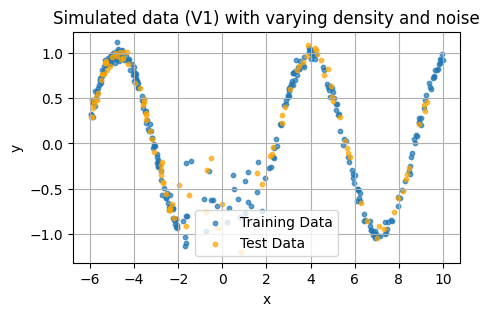

In [ ]:
# --- Generate and Visualise Data V1 ---
print("--- 1. Generating and Visualizing Data ---")
x_train, y_train, x_test, y_test = dg_1(N_points=400)
print(f"Using device: {DEVICE}")
print(f"Training data shape: x_train {x_train.shape}, y_train {y_train.shape}")
print(f"Test data shape: x_test {x_test.shape}, y_test {y_test.shape}")
# --- Plot the Data ---
plot_data(x_train, y_train, x_test, y_test,title='Simulated data (V1) with varying density and noise')

#### 2.1.2. A hard discontinuity data
The main chararacterstics for simulated data (V2) are:
- Discontinued function  : Creating 3 regions representing a non-continous function where a any MLP would find challenging to approximate the region 2 (where any smooth predictor $f$ would not be able to fit this region with very instable loss signal during the training).
- Keep the same density with a uniform number of data points across the 3 regions

For this simulated data, the major change from V1 would be to have a uniform distribution of the number of training data through the 3 regions and we add a had discontinuity with the `sign()` function in region 2 which would add jumps when going from $]-2,0]$ and $[0,-2[$


--- 2. Generating and Visualising Data V2 ---
Using device: cuda
Training data shape: x_train torch.Size([300, 1]), y_train torch.Size([300, 1])
Test data shape: x_test torch.Size([100, 1]), y_test torch.Size([100, 1])


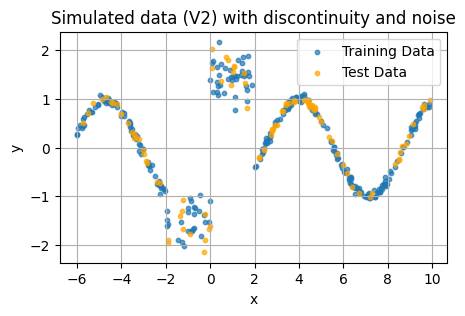

In [ ]:
# --- Generate and Visualise Data V2 ---
print("--- 2. Generating and Visualising Data V2 ---")
x_train_v2, y_train_v2, x_test_v2, y_test_v2 = dg_2(N_points=400)
print(f"Using device: {DEVICE}")
print(f"Training data shape: x_train {x_train_v2.shape}, y_train {y_train_v2.shape}")
print(f"Test data shape: x_test {x_test_v2.shape}, y_test {y_test_v2.shape}")
# --- Plot the Data ---
plot_data(x_train_v2,y_train_v2,x_test_v2,y_test_v2, title='Simulated data (V2) with discontinuity and noise')

## 3. Experimentation and tests

### 3.1. Model architecture
We define here as starting point two simples MLPs as :
- Predictor network $f(x)$
- Convction network $w(x)$

### 3.2. Loss functions
To compare with a baseline model, we will define 2 losses.
- Baseline Loss $L_{base}$ : we will use the standard MSE loss : $$ L_{base} = \frac{1}{N} \sum_{i=1}^{N}(f(x_i) - y_i)^2 = \frac{1}{N} \sum_{i=1}^{N}\ell_i$$
- Proposed new basline loss $L_{new}$ where we will use our proposed loss with the weighted average using $w(x_i)$ defined as $$ L_{new}= \frac{\sum_{i=1}^N w(x_i) \ell_i}{\sum_{j=1}^N w(x_j)}$$

In this proposed new loss, the numerator weights each sample squared error $\ell_i$ by its convicion score $w(x_i)$ and then it is divided by the sum over the entire dataset which would normalise the loss and discourages the model from becoming always unconfident to minimise the loss.

### 3.3. Training the model
Using the $L_{new}$ loss function, we use full-batch gradient descent for this simple inital test. The entiere training set is used to compute the loss and gradient in each epoch and we use the Adam optimiser simultaniously to update the parameters of $f$ and $w$. To compare with a baseline model, we also calculate a standard MSE loss for the $f$ model.
The first iteration of this tests gave results where the conviction value dropped at region 2 and never increased. Therefore, some modification were done on the test :
- increasing the number of hidden layers of both f and w networks
- increase the length of the region 3 as it seems that our model performance confidence dropped at region 2 (with low density data and increased noise) and stayed inconfident at region 3. By having larger dataset in region 3, we had positive results with the conviction model giving higher (confident) value at region 3 (from $x>4$).


--- 2. Training f+w Model with Proposed L_new Loss (Dataset V1) ---

--- Training f+w Model with Proposed L_new Loss ---
--- Starting joint training for 8000 epochs...
Epoch [ 800/8000], L_new: 0.180041, Numerator: 39.11, Denominator: 217.25, Avg w(x): 0.7242, Train MSE_f: 0.2279
Epoch [1600/8000], L_new: 0.113717, Numerator: 25.68, Denominator: 225.84, Avg w(x): 0.7528, Train MSE_f: 0.1588
Epoch [2400/8000], L_new: 0.045055, Numerator: 10.65, Denominator: 236.29, Avg w(x): 0.7876, Train MSE_f: 0.0655
Epoch [3200/8000], L_new: 0.008732, Numerator: 2.12, Denominator: 242.40, Avg w(x): 0.8080, Train MSE_f: 0.0091
Epoch [4000/8000], L_new: 0.006670, Numerator: 1.86, Denominator: 278.54, Avg w(x): 0.9285, Train MSE_f: 0.0069
Epoch [4800/8000], L_new: 0.006208, Numerator: 1.75, Denominator: 281.67, Avg w(x): 0.9389, Train MSE_f: 0.0067
Epoch [5600/8000], L_new: 0.005559, Numerator: 1.48, Denominator: 266.19, Avg w(x): 0.8873, Train MSE_f: 0.0065
Epoch [6400/8000], L_new: 0.004310, Numerato

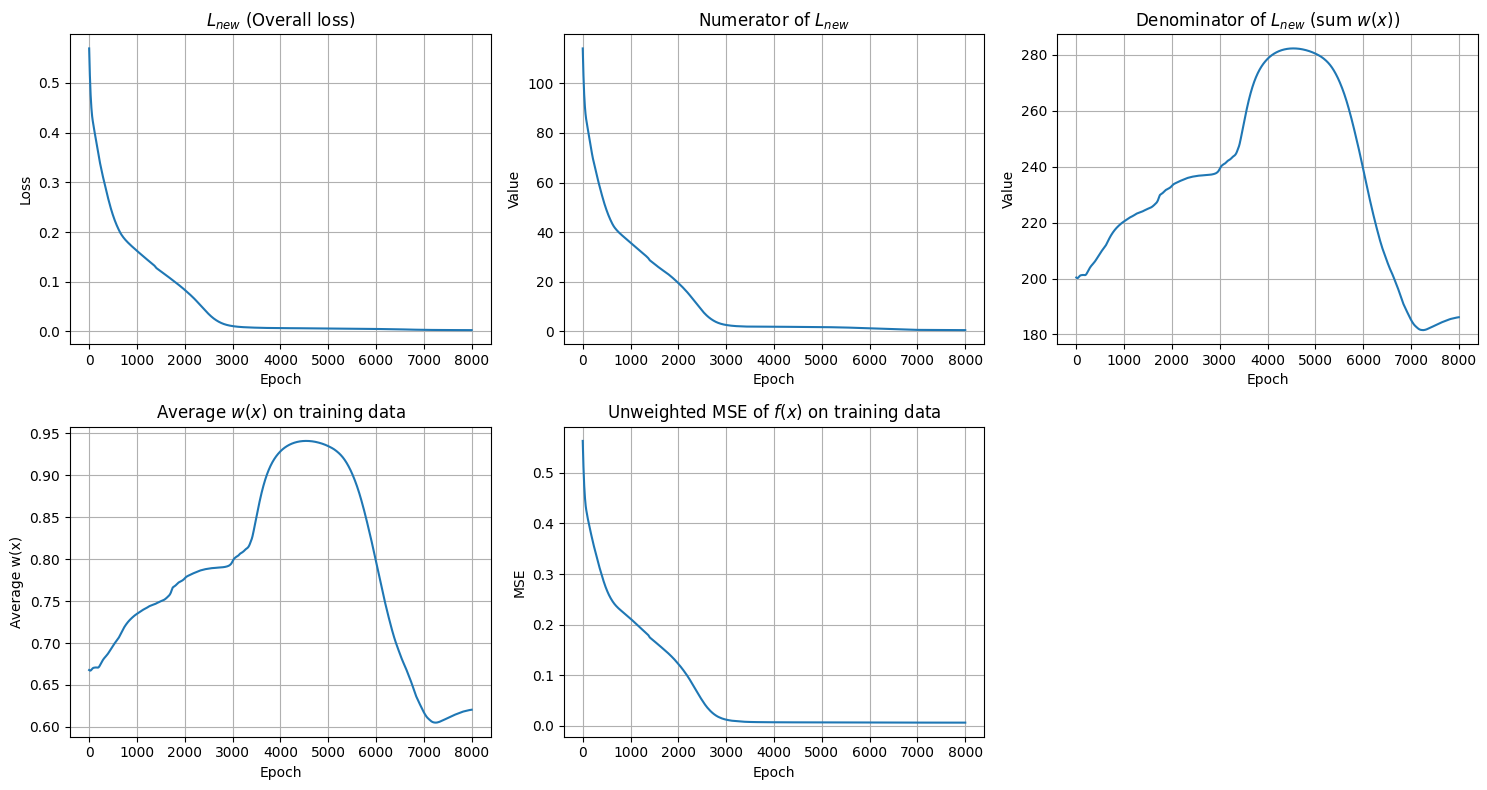

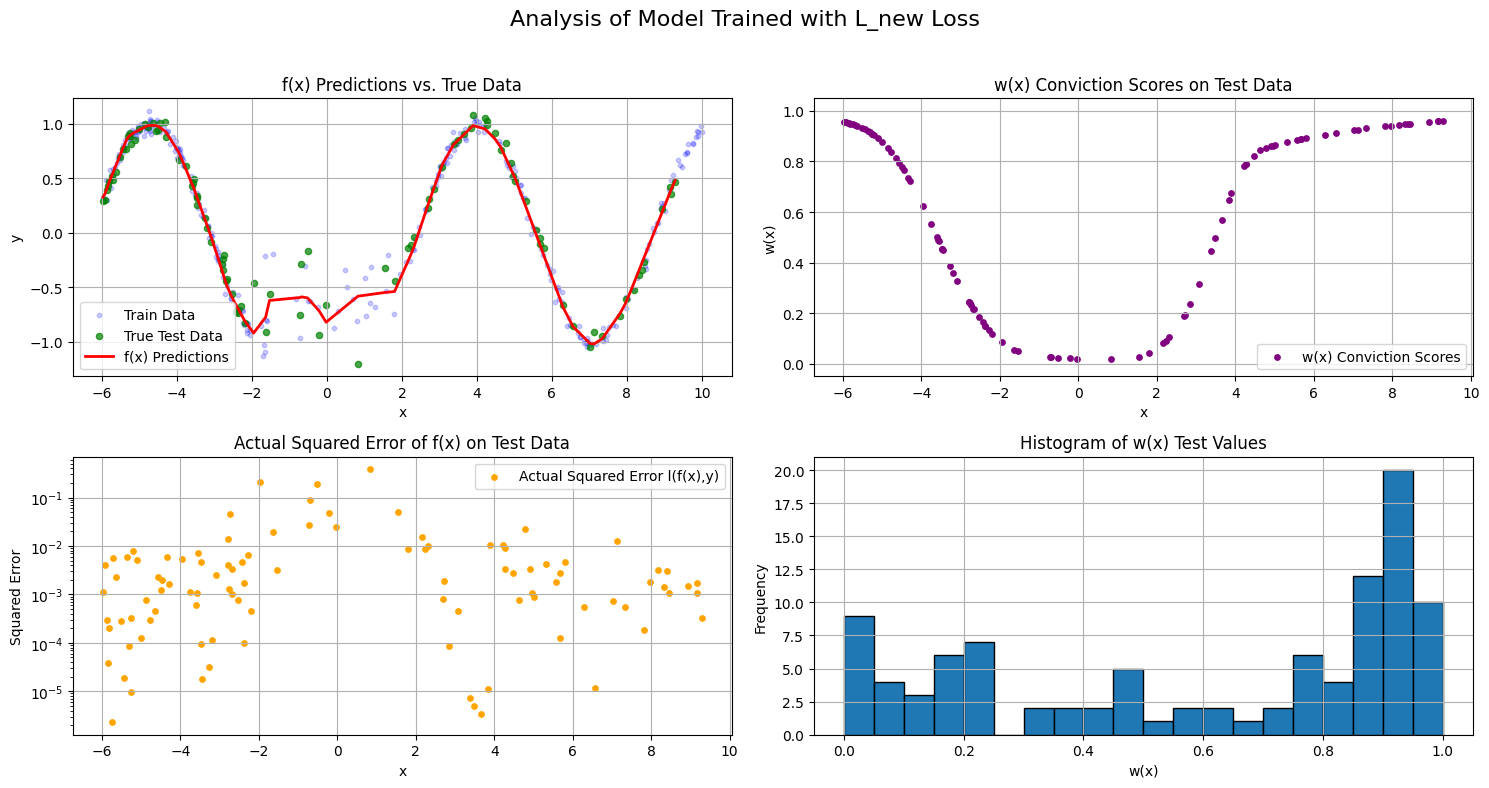

In [ ]:
# ==============================================================================
#                      L_new MODEL TRAINING & EVALUATION (Dataset V1)
# ==============================================================================
print("\n--- 2. Training f+w Model with Proposed L_new Loss (Dataset V1) ---")
# Instantiate models
f_model_v1, w_model_v1 = create_networks(input_dim=1, predictor_hidden_dims=[32, 32, 32], conviction_hidden_dims=[16, 16]) # Input dim is 1 for toy data
#f_model_v1 = PredictorNet()
#w_model_v1 = ConvictionNet()

# Train the model using the refactored function
history_lnew_v1 = train_model(
    f_model=f_model_v1,
    w_model=w_model_v1,
    x_train=x_train,
    y_train=y_train,
    training_strategy='joint',
    epochs=EPOCHS_LNEW,
    learning_rate=LEARNING_RATE,
    device=DEVICE
)

# Evaluate the model using the refactored function
print("\n--- L_new Model evaluation results (Dataset V1) ---")
evaluation_results_lnew_v1 = evaluate_model(
    f_model=f_model_v1,
    w_model=w_model_v1,
    x_test=x_test,
    y_test=y_test,
    device=DEVICE
)

# --- Visualisation for L_new model (Dataset V1) ---
if history_lnew_v1:
    plot_L_new(history_lnew_v1)

if evaluation_results_lnew_v1:
    plot_xy_L_new(
        x_train=x_train,
        y_train=y_train,
        x_test=evaluation_results_lnew_v1['x_test'],
        y_test=evaluation_results_lnew_v1['y_test'],
        #x_test=x_test,
        #y_test=y_test,
        f_test_preds=evaluation_results_lnew_v1['f_test_preds'],
        w_test_preds=evaluation_results_lnew_v1['w_test_preds'],
        l_test_actual=evaluation_results_lnew_v1['l_test_actual']
    )


--- 2. Training f+w Model with Proposed L_new Loss (Dataset V2) ---

--- Training f+w Model with Proposed L_new Loss ---
--- Starting joint training for 8000 epochs...
Epoch [ 800/8000], L_new: 0.320335, Numerator: 74.73, Denominator: 233.28, Avg w(x): 0.7776, Train MSE_f: 0.3466
Epoch [1600/8000], L_new: 0.126633, Numerator: 21.69, Denominator: 171.27, Avg w(x): 0.5709, Train MSE_f: 0.1662
Epoch [2400/8000], L_new: 0.036064, Numerator: 3.11, Denominator: 86.23, Avg w(x): 0.2874, Train MSE_f: 0.1451
Epoch [3200/8000], L_new: 0.015490, Numerator: 1.06, Denominator: 68.36, Avg w(x): 0.2279, Train MSE_f: 0.1515
Epoch [4000/8000], L_new: 0.008237, Numerator: 0.47, Denominator: 57.56, Avg w(x): 0.1919, Train MSE_f: 0.1672
Epoch [4800/8000], L_new: 0.005323, Numerator: 0.27, Denominator: 51.17, Avg w(x): 0.1706, Train MSE_f: 0.1802
Epoch [5600/8000], L_new: 0.004049, Numerator: 0.19, Denominator: 47.10, Avg w(x): 0.1570, Train MSE_f: 0.1931
Epoch [6400/8000], L_new: 0.003419, Numerator: 0.1

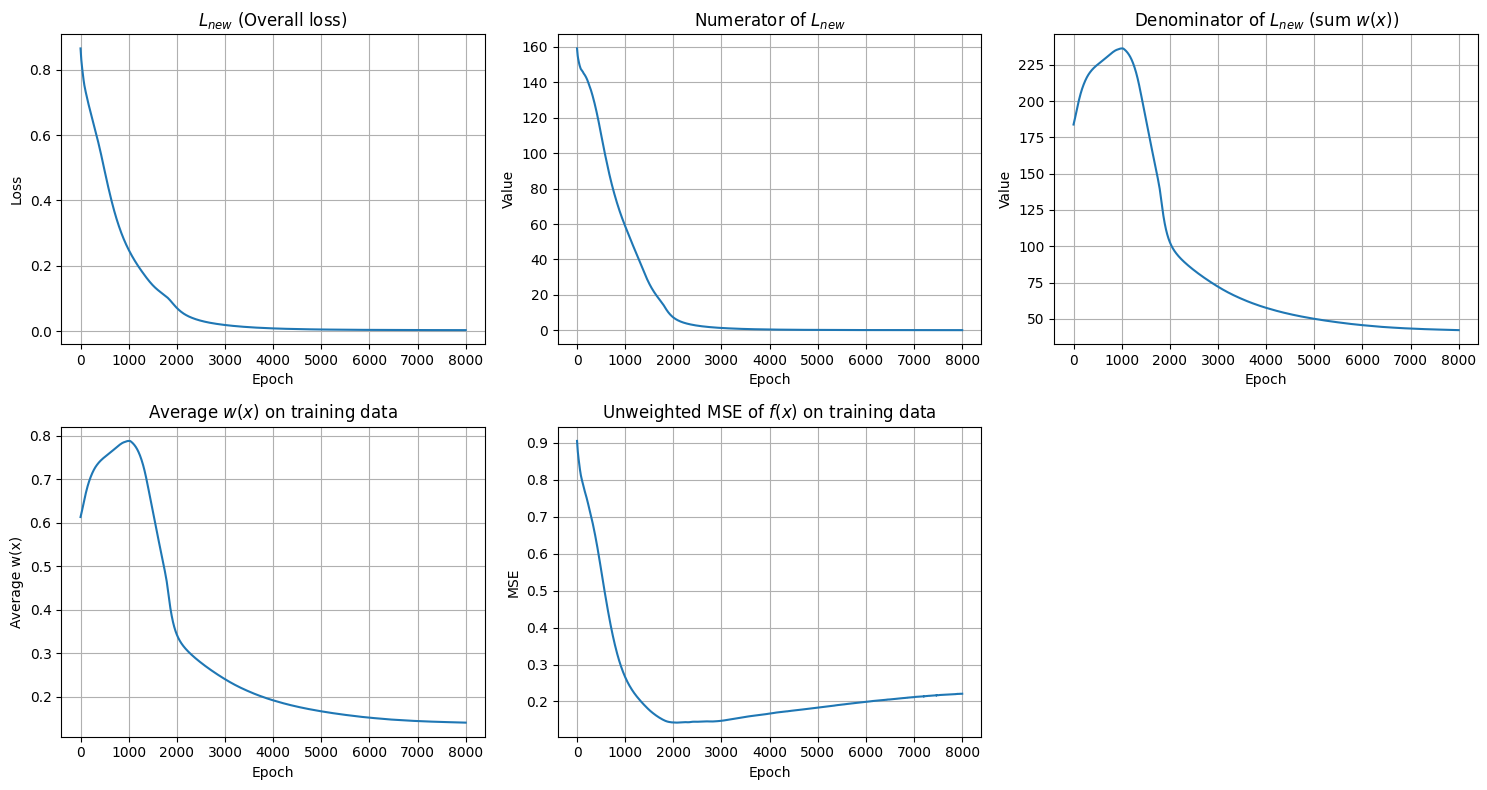

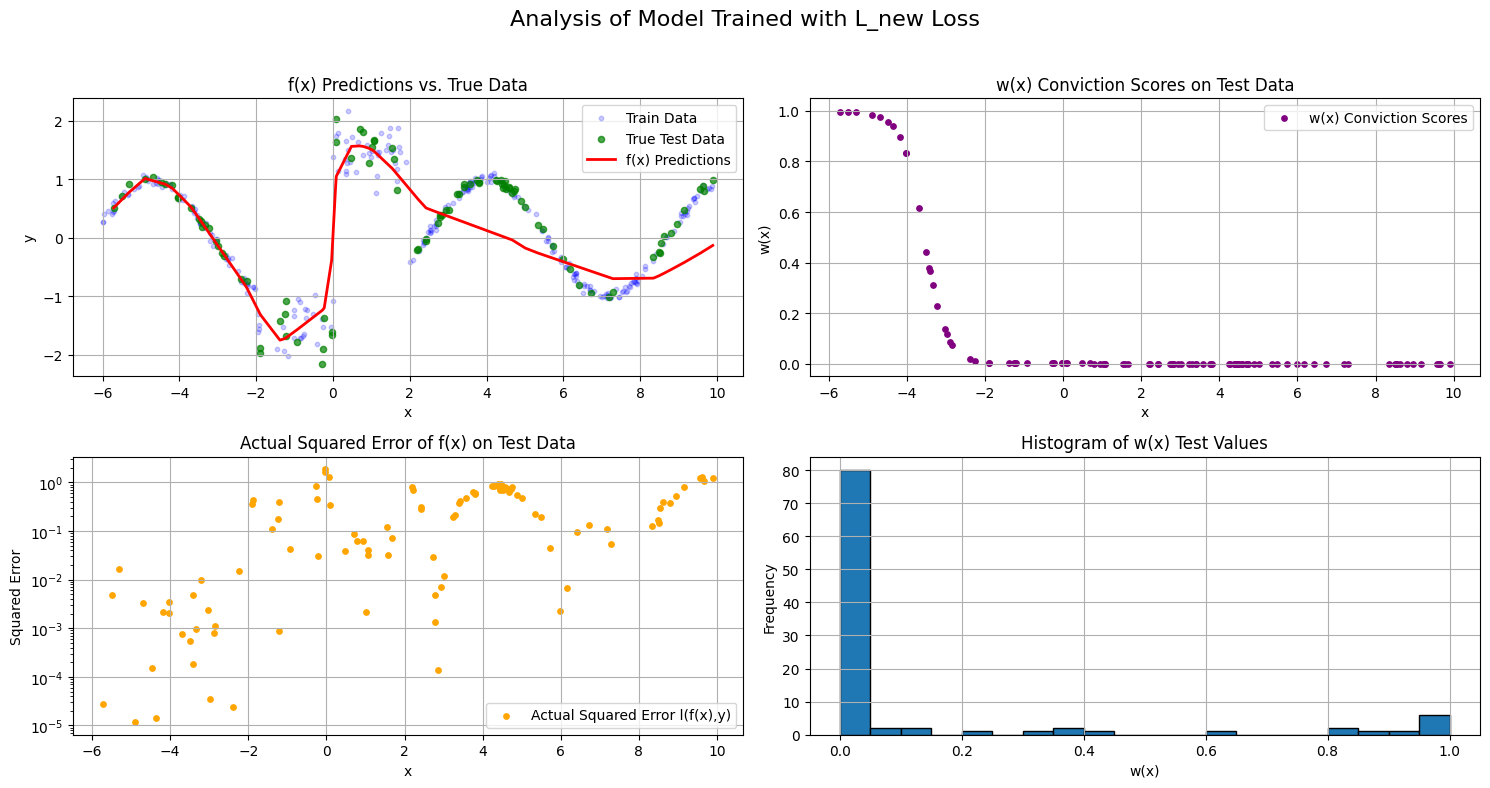

In [ ]:
# ==============================================================================
#                      L_new MODEL TRAINING & EVALUATION (Dataset V2)
# ==============================================================================
print("\n--- 2. Training f+w Model with Proposed L_new Loss (Dataset V2) ---")
# Instantiate models

f_model_v2, w_model_v2 = create_networks(input_dim=1) # Input dim is 1 for toy data
#f_model_v2 = PredictorNet()
#w_model_v2 = ConvictionNet()

# Train the model using the refactored function
history_lnew_v2 = train_model(
    f_model=f_model_v2,
    w_model=w_model_v2,
    x_train=x_train_v2,
    y_train=y_train_v2,
    training_strategy='joint',
    epochs=EPOCHS_LNEW,
    learning_rate=LEARNING_RATE,
    device=DEVICE
)

# Evaluate the model using the refactored function
print("\n--- L_new Model evaluation results (Dataset V2) ---")
evaluation_results_lnew_v2 = evaluate_model(
    f_model=f_model_v2,
    w_model=w_model_v2,
    x_test=x_test_v2,
    y_test=y_test_v2,
    device=DEVICE
)

# --- Visualisation for L_new model (Dataset V2) ---
if history_lnew_v2:
    plot_L_new(history_lnew_v2)

if evaluation_results_lnew_v2:
    plot_xy_L_new(
        x_train=x_train_v2,
        y_train=y_train_v2,
        x_test=evaluation_results_lnew_v2['x_test'],
        y_test=evaluation_results_lnew_v2['y_test'],
        f_test_preds=evaluation_results_lnew_v2['f_test_preds'],
        w_test_preds=evaluation_results_lnew_v2['w_test_preds'],
        l_test_actual=evaluation_results_lnew_v2['l_test_actual']
    )

### 3.4. Baseline Training with MSE
To compare the performance of the $L_{new}$ loss, we train the `PredictorNet` ($f(x)$) separately using the standard Mean Squared Error (MSE) loss function:

$$ L_{base} = \frac{1}{N} \sum_{i=1}^{N}(f(x_i) - y_i)^2 $$

In [ ]:
# ==============================================================================
#                     BASELINE MODEL TRAINING & EVALUATION (Dataset V1)
# ==============================================================================
print("\n--- 3. Training Baseline Model with Standard MSE Loss (Dataset V1)---")
# Instantiate models
f_baseline_model_v1, w_baseline_model_v1 = create_networks(input_dim=1, predictor_hidden_dims=[32, 32, 32], conviction_hidden_dims=[16, 16]) # Input dim is 1 for toy data
#f_model_v1 = PredictorNet()
#w_model_v1 = ConvictionNet()

# Train the model using the refactored function
history_baseline_v1 = train_model(
    f_model=f_baseline_model_v1,
    w_model=w_baseline_model_v1,
    x_train=x_train,
    y_train=y_train,
    training_strategy='f_only',
    epochs=EPOCHS_LNEW,
    learning_rate=LEARNING_RATE,
    device=DEVICE
)

# Evaluate the model using the refactored function
print("\n--- Baseline Model Evaluation Results (Dataset V1) ---")
evaluation_results_lnew_v1 = evaluate_model(
    f_model=f_baseline_model_v1,
    w_model=None,
    x_test=x_test,
    y_test=y_test,
    device=DEVICE
)

# --- Visualisation for L_new model (Dataset V1) ---
# if history_lnew_v1:
#     plot_L_new(history_lnew_v1)

# if evaluation_results_lnew_v1:
#     plot_xy_L_new(
#         x_train=x_train,
#         y_train=y_train,
#         x_test=evaluation_results_lnew_v1['x_test'],
#         y_test=evaluation_results_lnew_v1['y_test'],
#         #x_test=x_test,
#         #y_test=y_test,
#         f_test_preds=evaluation_results_lnew_v1['f_test_preds'],
#         w_test_preds=evaluation_results_lnew_v1['w_test_preds'],
#         l_test_actual=evaluation_results_lnew_v1['l_test_actual']
#     )


--- 3. Training Baseline Model with Standard MSE Loss (Dataset V1)---

--- Training PredictorNet (f(x)) alone with Standard MSE Loss ---
Starting f(x) only training for 8000 epochs...
Epoch [ 800/8000], f(x) only MSE: 0.200423
Epoch [1600/8000], f(x) only MSE: 0.079757
Epoch [2400/8000], f(x) only MSE: 0.013942
Epoch [3200/8000], f(x) only MSE: 0.008203
Epoch [4000/8000], f(x) only MSE: 0.006981
Epoch [4800/8000], f(x) only MSE: 0.006612
Epoch [5600/8000], f(x) only MSE: 0.006383
Epoch [6400/8000], f(x) only MSE: 0.006146
Epoch [7200/8000], f(x) only MSE: 0.005973
Epoch [8000/8000], f(x) only MSE: 0.005848
f(x) only training finished.

--- Baseline Model Evaluation Results (Dataset V1) ---
Predictor f(x) Test MSE: 0.0140


In [ ]:
# ==============================================================================
#                     BASELINE MODEL TRAINING & EVALUATION (Dataset V2)
# ==============================================================================
print("\n--- 4. Training Baseline Model with Standard MSE Loss (Dataset V2)---")
# Instantiate models
f_baseline_model_v2, w_baseline_model_v2 = create_networks(input_dim=1, predictor_hidden_dims=[32, 32, 32], conviction_hidden_dims=[16, 16]) # Input dim is 1 for toy data
#f_model_v1 = PredictorNet()
#w_model_v1 = ConvictionNet()

# Train the model using the refactored function
history_baseline_v2 = train_model(
    f_model=f_baseline_model_v2,
    w_model=w_baseline_model_v2,
    x_train=x_train,
    y_train=y_train,
    training_strategy='f_only',
    epochs=EPOCHS_LNEW,
    learning_rate=LEARNING_RATE,
    device=DEVICE
)

# Evaluate the model using the refactored function
print("\n--- Baseline Model Evaluation Results (Dataset V2) ---")
evaluation_results_lnew_v2 = evaluate_model(
    f_model=f_baseline_model_v2,
    w_model=None,
    x_test=x_test,
    y_test=y_test,
    device=DEVICE
)

# --- Visualisation for L_new model (Dataset V1) ---
# if history_lnew_v1:
#     plot_L_new(history_lnew_v1)

# if evaluation_results_lnew_v1:
#     plot_xy_L_new(
#         x_train=x_train,
#         y_train=y_train,
#         x_test=evaluation_results_lnew_v1['x_test'],
#         y_test=evaluation_results_lnew_v1['y_test'],
#         #x_test=x_test,
#         #y_test=y_test,
#         f_test_preds=evaluation_results_lnew_v1['f_test_preds'],
#         w_test_preds=evaluation_results_lnew_v1['w_test_preds'],
#         l_test_actual=evaluation_results_lnew_v1['l_test_actual']
#     )


--- 4. Training Baseline Model with Standard MSE Loss (Dataset V2)---

--- Training PredictorNet (f(x)) alone with Standard MSE Loss ---
Starting f(x) only training for 8000 epochs...
Epoch [ 800/8000], f(x) only MSE: 0.206328
Epoch [1600/8000], f(x) only MSE: 0.082034
Epoch [2400/8000], f(x) only MSE: 0.013216
Epoch [3200/8000], f(x) only MSE: 0.008146
Epoch [4000/8000], f(x) only MSE: 0.007429
Epoch [4800/8000], f(x) only MSE: 0.007130
Epoch [5600/8000], f(x) only MSE: 0.006911
Epoch [6400/8000], f(x) only MSE: 0.006704
Epoch [7200/8000], f(x) only MSE: 0.006457
Epoch [8000/8000], f(x) only MSE: 0.006225
f(x) only training finished.

--- Baseline Model Evaluation Results (Dataset V2) ---
Predictor f(x) Test MSE: 0.0129


## 4. Evaluation and analysis
We analyse and compare the results from the baseline loss MSE and the jointly training $f$ and $w$ with the proposed $L_{new}$.
The first results from the training with $L_{new}$ have mixed results noting the following :
- In our first test, the primary model $f$ achieved a test MSE of 0.159 which is higher than the baseline model using MSE of 0.007. This indicates that our loss, in its current form and with the first small and simple MLE architecture reduce the perdictive performance of $f$ without brining additional benefit. By increasing the size of $f(x)$ we had a comparable result than the baseline model.
- With the second increased size model, we had the following results :
```
Test MSE for f(x) trained with L_new: 0.0134
Test MSE for f(x) trained with Baseline MSE: 0.0128
```

![image-2.png](attachment:image-2.png)


--- Comparing L_new and Baseline Models (Dataset V1) ---
Test MSE for f(x) trained with L_new - Dataset V1: 0.0135
Test MSE for f(x) trained with Baseline MSE - Dataset V1: 0.0140


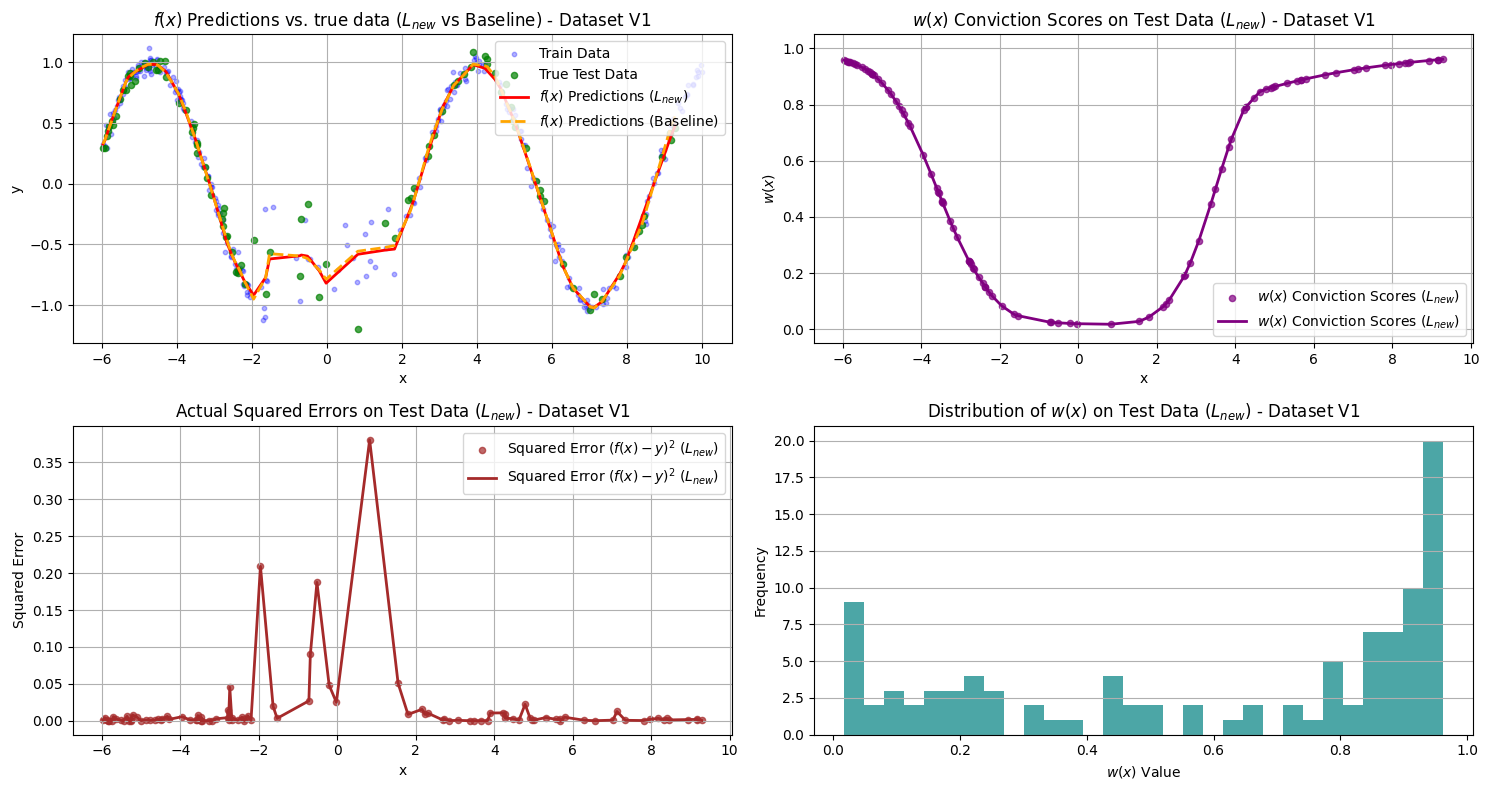

In [ ]:
# ==============================================================================
#                     COMPARISON AND VISUALIZATION (Dataset V1)
# ==============================================================================
print("\n--- Comparing L_new and Baseline Models (Dataset V1) ---")

# Call the comparison and plotting function for Dataset V1
compare_models_plot(
    f_lnew_model=f_model_v1,
    w_lnew_model=w_model_v1,
    f_baseline_model=f_baseline_model_v1,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    device=DEVICE,
    title_suffix=' - Dataset V1'
)


--- Comparing L_new and Baseline Models (Dataset V2) ---
Test MSE for f(x) trained with L_new - Dataset V2: 0.3404
Test MSE for f(x) trained with Baseline MSE - Dataset V2: 0.6886


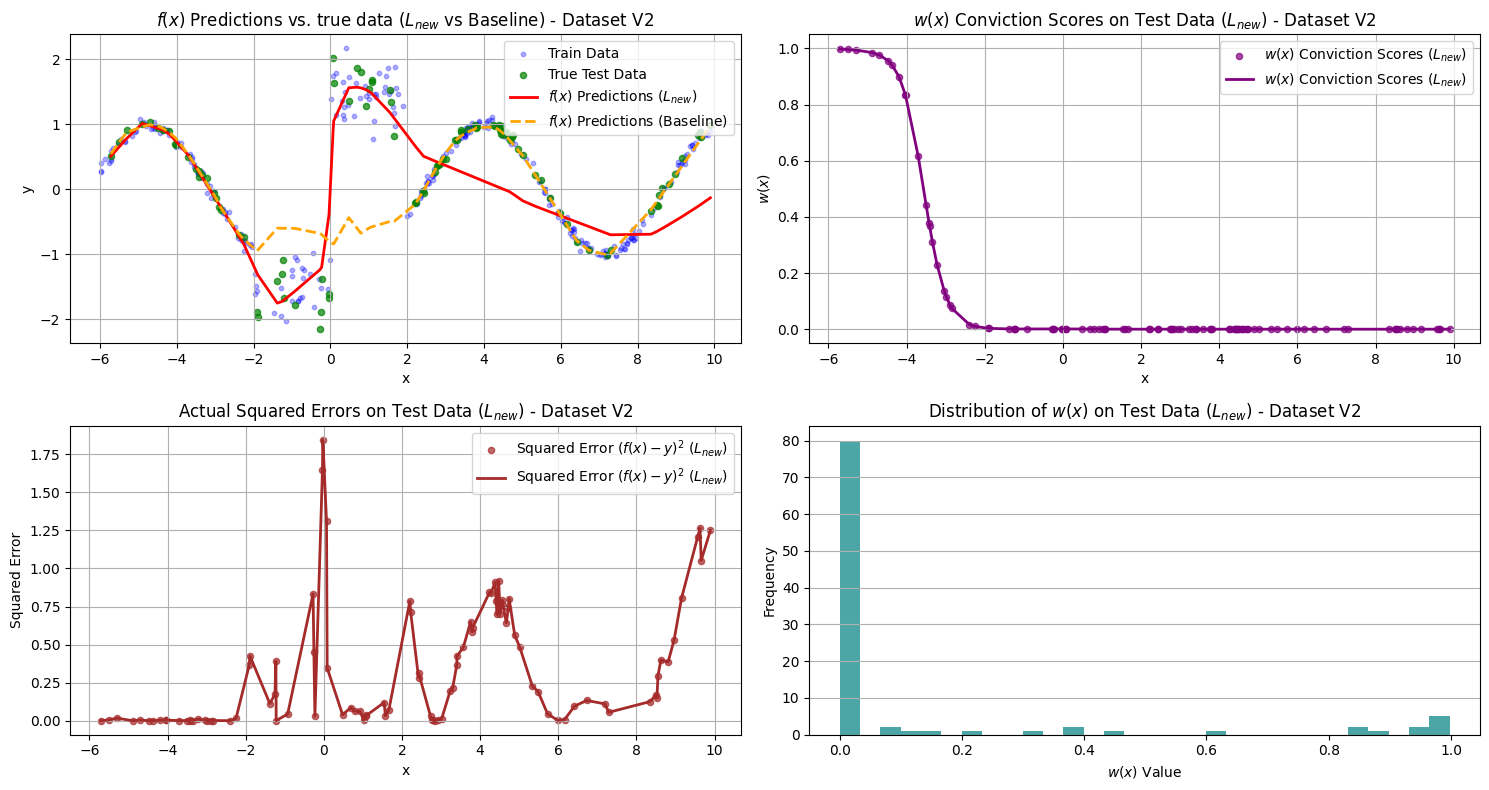

In [ ]:
# ==============================================================================
#                     COMPARISON AND VISUALIZATION (Dataset V2)
# ==============================================================================
print("\n--- Comparing L_new and Baseline Models (Dataset V2) ---")

# Call the comparison and plotting function for Dataset V2
compare_models_plot(
    f_lnew_model=f_model_v2,
    w_lnew_model=w_model_v2,
    f_baseline_model=f_baseline_model_v2,
    x_train=x_train_v2,
    y_train=y_train_v2,
    x_test=x_test_v2,
    y_test=y_test_v2,
    device=DEVICE,
    title_suffix=' - Dataset V2'
)

## 5. Discussion and next steps
### 5.1 Key finding
The preliminary experiment preovided first idea on the direction to go with the following observation :
- the proposed loss function $L_{new}$ create more complexity in the optimisation process where the primary model's predictive performance was degraded compared to standard baseline with the first small 3 layers MLP architecture. After increasing the size of the layers of the primary model and adding an additional 32x32 layer, we succeed to have comparable performance with the proposed $L_{new}$
- With the first models, the conviction network $w$ didn't learn effectiveley to differentiate all the regions of high and low certainty. It assigned relatively low conviction to a majorty of the inputs, this was then corrected with the increased size model.
- the global denominator term prevented as designed the total collapse of the conviction scores to zero but it was insufficient on its own to have a useful and calibrated convicion function with the network $w$
### 5.2 Result interpretation
**Summary of L_new training:**
- The `L_new` loss generally decreased over epochs, suggesting the model was learning but it plateaued towards the end.
- The average `w(x)` on the training data initially increased and then stabilised around 0.6 at the end of training. This indicates the conviction network did not collapse to zero, and maintained a moderate average conviction.
- The unweighted training MSE of `f(x)` under `L_new` training decreased significantly and reached a low value of 0.0134, indicating the proposed second larger `f(x)` model was able to fit the training data well, even when optimising the joint `L_new` loss.
- The f(x) predictions from the larger model appear to fit the smooth regions (Region 1 and 3) and the linear interpolation in Region 2 much better than the previous smaller model. It captures the overall shape of the data well across the entire range.

**Evaluation of w(x) trained with L_new:**
- The w(x) scores on the test data show lower values in the central region (-2 to 2), which is the high-noise, sparse region. Higher conviction scores are generally observed in the smoother, denser regions outside of this central area (x < -2 and x > 2). This aligns with the expectation that w(x) should be lower where the model is less certain due to higher noise. There is also some variability in conviction within the smoother regions, potentially related to data density or specific data points.
- The actual squared errors are visibly higher in the central region where w(x) is lower. There is a clear qualitative alignment between higher error and lower conviction across the x-axis.
- The histogram of $w(x)$ shows a distribution of $w(x)$ values across the range, with a peak around 0.8-0.9. The average w(x) on the test set was 0.625. This distribution suggests the model is using a range of conviction scores, reflecting varying levels of certainty as needed.

**Comparison with Baseline (L_original):**
- The baseline model trained with standard MSE achieved a Test MSE that is very close to the Test MSE of the f(x) from the $L_{new}$ model. This indicates that with a sufficiently large model, the `L_new` loss can achieve comparable predictive performance to standard MSE while also training a conviction network.

**Initial conclusions:**
- The proposed L_new loss successfully encourages w(x) to reflect f(x)'s reliability on this toy problem. The conviction scores are lower in the high-noise region and higher in the smoother, lower-noise regions.
- The denominator term effectively prevented w(x) from completely collapsing to zero, maintaining a reasonable average conviction score.
- Using a larger predictor network significantly improved the predictive performance of f(x) trained with L_new, bringing it in line with the baseline MSE performance. This suggests that the `L_new` loss does not compromise predictive accuracy when the model capacity is sufficient.

**Potential Issues / Further Investigation:**
- The full-batch implementation used here is not scalable to large datasets. The next crucial step is to explore and implement the mini-batch approximation for the denominator to make this approach feasible for larger datasets and assess its impact on both f(x) performance and w(x) meaningfulness.
- Investigate the calibration of the conviction scores by using more challenging dataset (as the proposed discontinuity simulated data and then on real world time series with various noises)
- The recovery of the confidence of the conviction network was slow ($w(x) > 0.5$ only when $x>4$). For this reason to validate our test we had to increase the generated data size of the 3rd region. This could become problematic with real data where we can have various changepoints that needs to be detected faster and avoid the conviction model being always giving low confidence values.

### 5.2 Next steps
This simple first result needs to be developed by trying to have a bigger model to see if the auxiliary network ($w$) could learn better the conviction function with more challenging data.
We can use as a next step architecture similars to the one that we studied as part of the litterature review (ConfidNet or SelectiveNet). Then if we start to have first satisfying results, we can then test the second more challenging simulated datasets with the discontinuity of data before testing on real-world data such as the london weather or financial time series.

## 4. Training w after freezing f(x)
The training process follows these steps: 1. Train the predictor model (f(x)) independently using Mean Squared Error (MSE). 2. Freeze the weights and parameters of the trained predictor model. 3. Train the confidence model (w(x)) using the L_new loss function, keeping the predictor model's parameters fixed. If fixing the error is not possible, diagnose the error.

### 4.1. Training with Separate Freeze Strategy
Here, we train the predictor $f(x)$ with MSE first, then freeze its weights and train the conviction model $w(x)$ with the $L_{new}$ loss.


--- 4. Separate Freeze Model Training (Dataset V1) ---
--- Starting separate training: f(x) with MSE, then w(x) with L_new (f(x) frozen) ---

--- Step 1: Training f(x) with MSE ---
  f(x) training - Epoch [ 800/8000], MSE: 0.1948
  f(x) training - Epoch [1600/8000], MSE: 0.0629
  f(x) training - Epoch [2400/8000], MSE: 0.0147
  f(x) training - Epoch [3200/8000], MSE: 0.0090
  f(x) training - Epoch [4000/8000], MSE: 0.0075
  f(x) training - Epoch [4800/8000], MSE: 0.0070
  f(x) training - Epoch [5600/8000], MSE: 0.0067
  f(x) training - Epoch [6400/8000], MSE: 0.0064
  f(x) training - Epoch [7200/8000], MSE: 0.0061
  f(x) training - Epoch [8000/8000], MSE: 0.0060
--- Step 1: f(x) training finished. ---

--- Step 2: Freezing f(x) parameters ---
--- Step 2: f(x) parameters frozen. ---

--- Step 3: Training w(x) with L_new (f(x) frozen) ---
  w(x) training - Epoch [ 800/8000], L_new: 0.004797, Numerator: 0.95, Denominator: 198.01, Avg w(x): 0.6600
  w(x) training - Epoch [1600/8000], L_ne

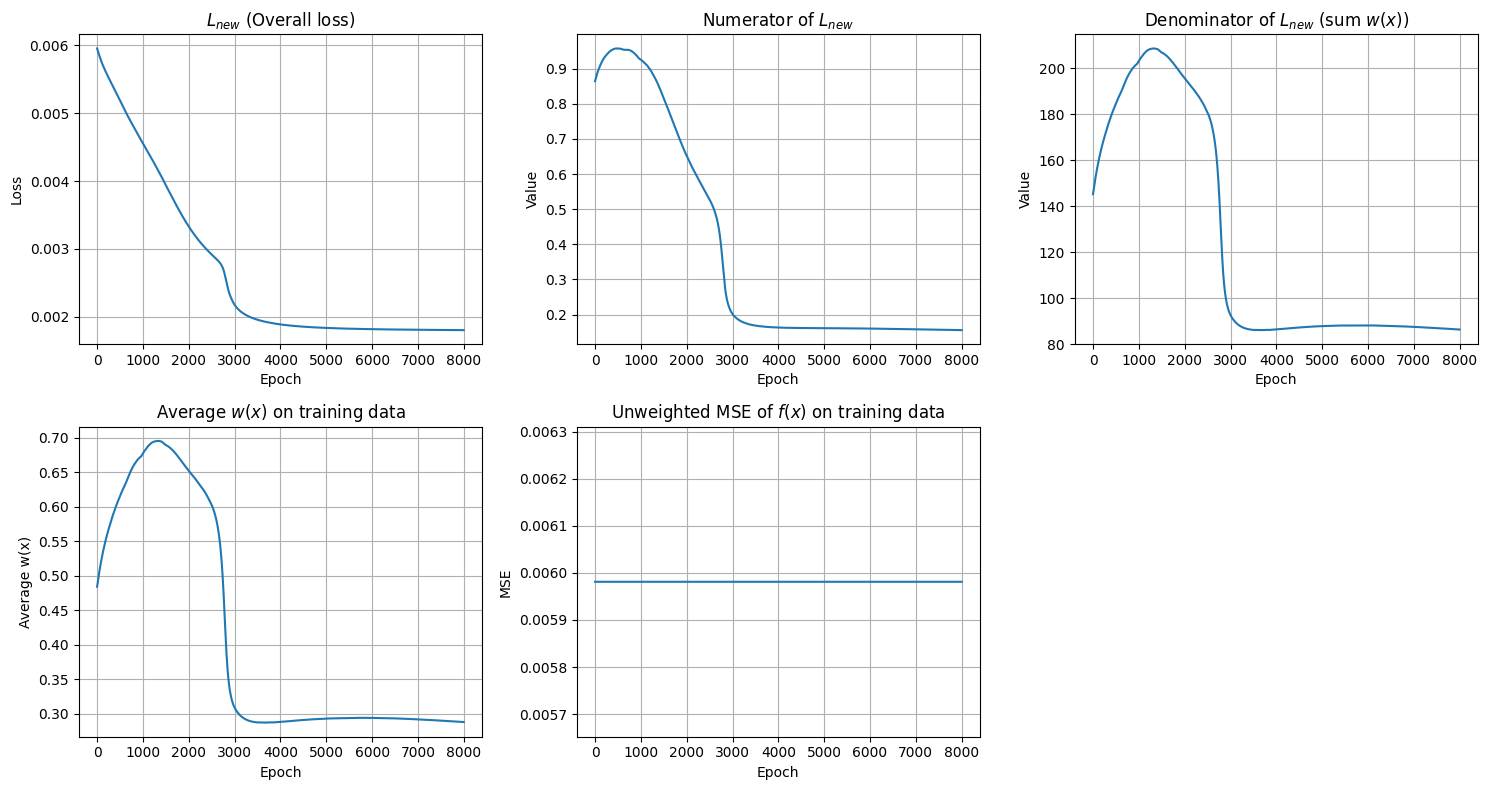

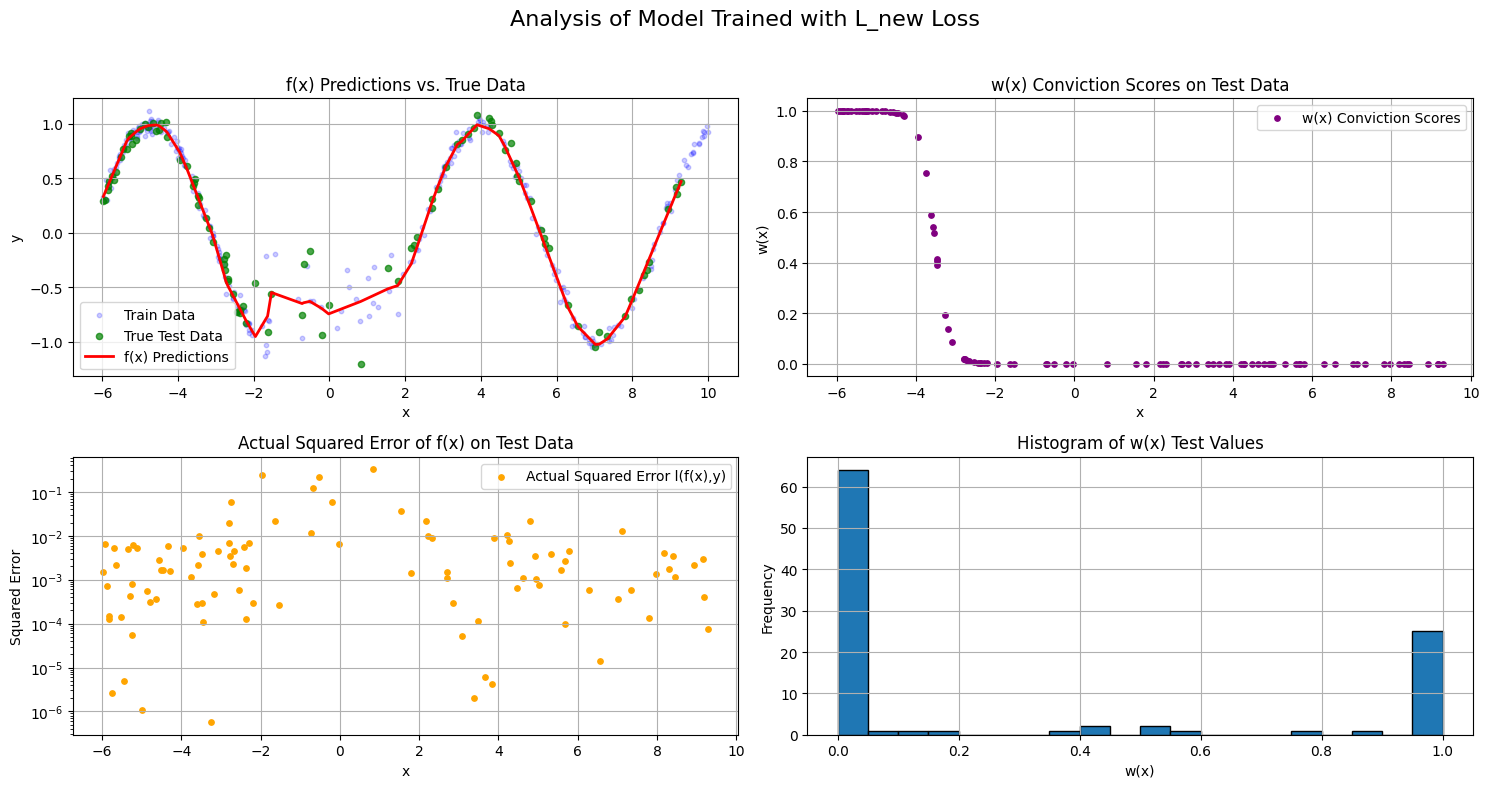

In [ ]:
# ==============================================================================
#                      SEPARATE FREEZE MODEL TRAINING & EVALUATION (Dataset V1)
# ==============================================================================
print("\n--- 4. Separate Freeze Model Training (Dataset V1) ---")
# Instantiate models (fresh instances for this training strategy)
f_separate_v1, w_separate_v1 = create_networks(input_dim=1)

# Train the models using the new 'separate_freeze_w' strategy
history_separate_v1 = train_model(
    f_model=f_separate_v1,
    w_model=w_separate_v1,
    x_train=x_train,
    y_train=y_train,
    training_strategy='separate_freeze_w',
    epochs=EPOCHS_LNEW,
    learning_rate=LEARNING_RATE,
    device=DEVICE
)

# Evaluate the models
print("\n--- Separate Freeze Model Evaluation Results (Dataset V1) ---")
evaluation_results_separate_v1 = evaluate_model(
    f_model=f_separate_v1,
    w_model=w_separate_v1,
    x_test=x_test,
    y_test=y_test,
    device=DEVICE
)

# --- Visualisation for Separate Freeze model (Dataset V1) ---
if history_separate_v1 and 'epoch_loss' in history_separate_v1: # Check if w(x) history is available
     plot_L_new(history_separate_v1)

if evaluation_results_separate_v1:
    plot_xy_L_new(
        x_train=x_train,
        y_train=y_train,
        x_test=evaluation_results_separate_v1['x_test'],
        y_test=evaluation_results_separate_v1['y_test'],
        f_test_preds=evaluation_results_separate_v1['f_test_preds'],
        w_test_preds=evaluation_results_separate_v1['w_test_preds'],
        l_test_actual=evaluation_results_separate_v1['l_test_actual']
    )


--- 4. Separate Freeze Model Training (Dataset V2) ---
--- Starting separate training: f(x) with MSE, then w(x) with L_new (f(x) frozen) ---

--- Step 1: Training f(x) with MSE ---
  f(x) training - Epoch [ 800/8000], MSE: 0.3440
  f(x) training - Epoch [1600/8000], MSE: 0.1903
  f(x) training - Epoch [2400/8000], MSE: 0.0750
  f(x) training - Epoch [3200/8000], MSE: 0.0431
  f(x) training - Epoch [4000/8000], MSE: 0.0351
  f(x) training - Epoch [4800/8000], MSE: 0.0297
  f(x) training - Epoch [5600/8000], MSE: 0.0271
  f(x) training - Epoch [6400/8000], MSE: 0.0243
  f(x) training - Epoch [7200/8000], MSE: 0.0223
  f(x) training - Epoch [8000/8000], MSE: 0.0205
--- Step 1: f(x) training finished. ---

--- Step 2: Freezing f(x) parameters ---
--- Step 2: f(x) parameters frozen. ---

--- Step 3: Training w(x) with L_new (f(x) frozen) ---
  w(x) training - Epoch [ 800/8000], L_new: 0.014051, Numerator: 3.13, Denominator: 222.58, Avg w(x): 0.7419
  w(x) training - Epoch [1600/8000], L_ne

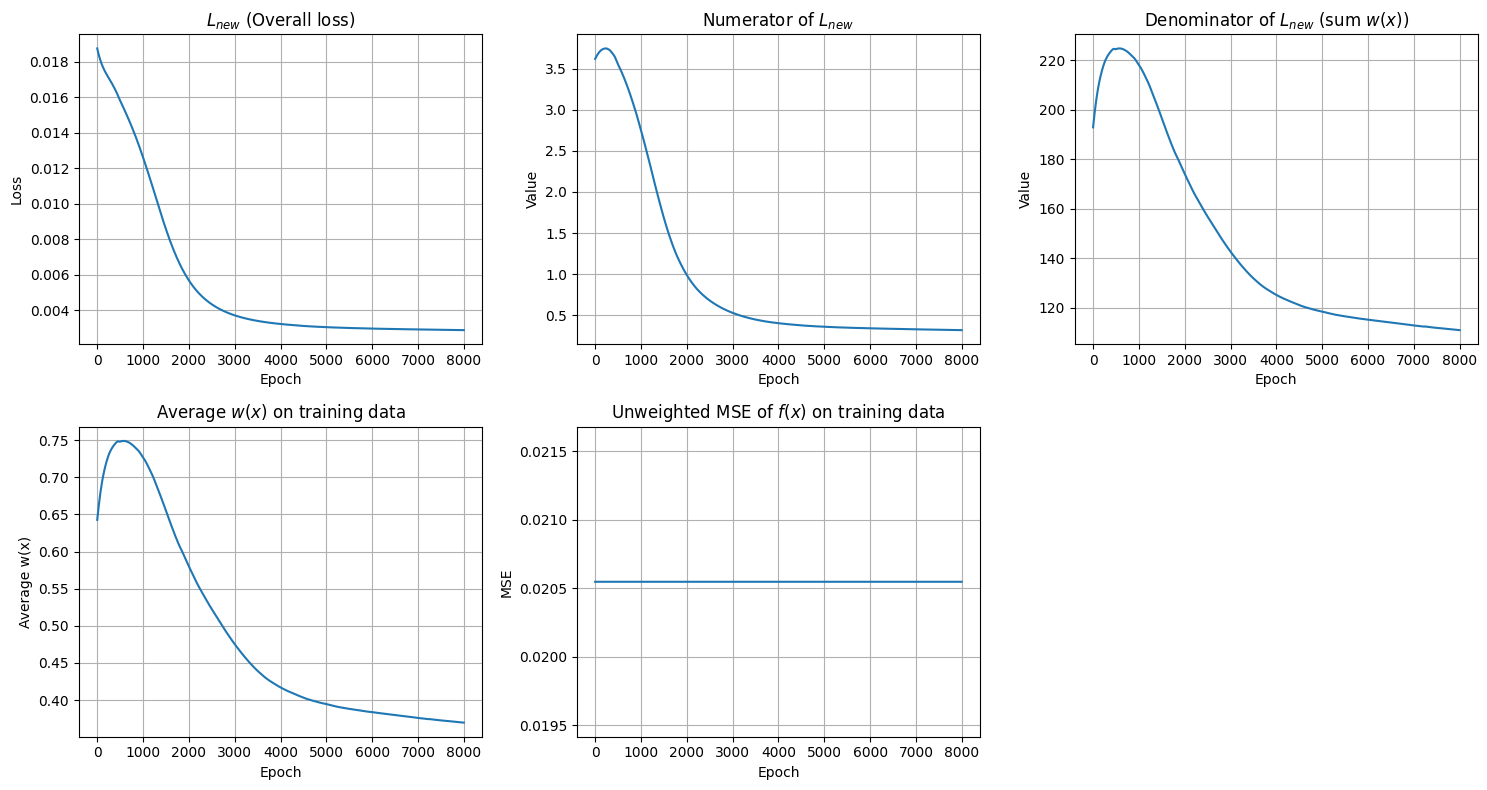

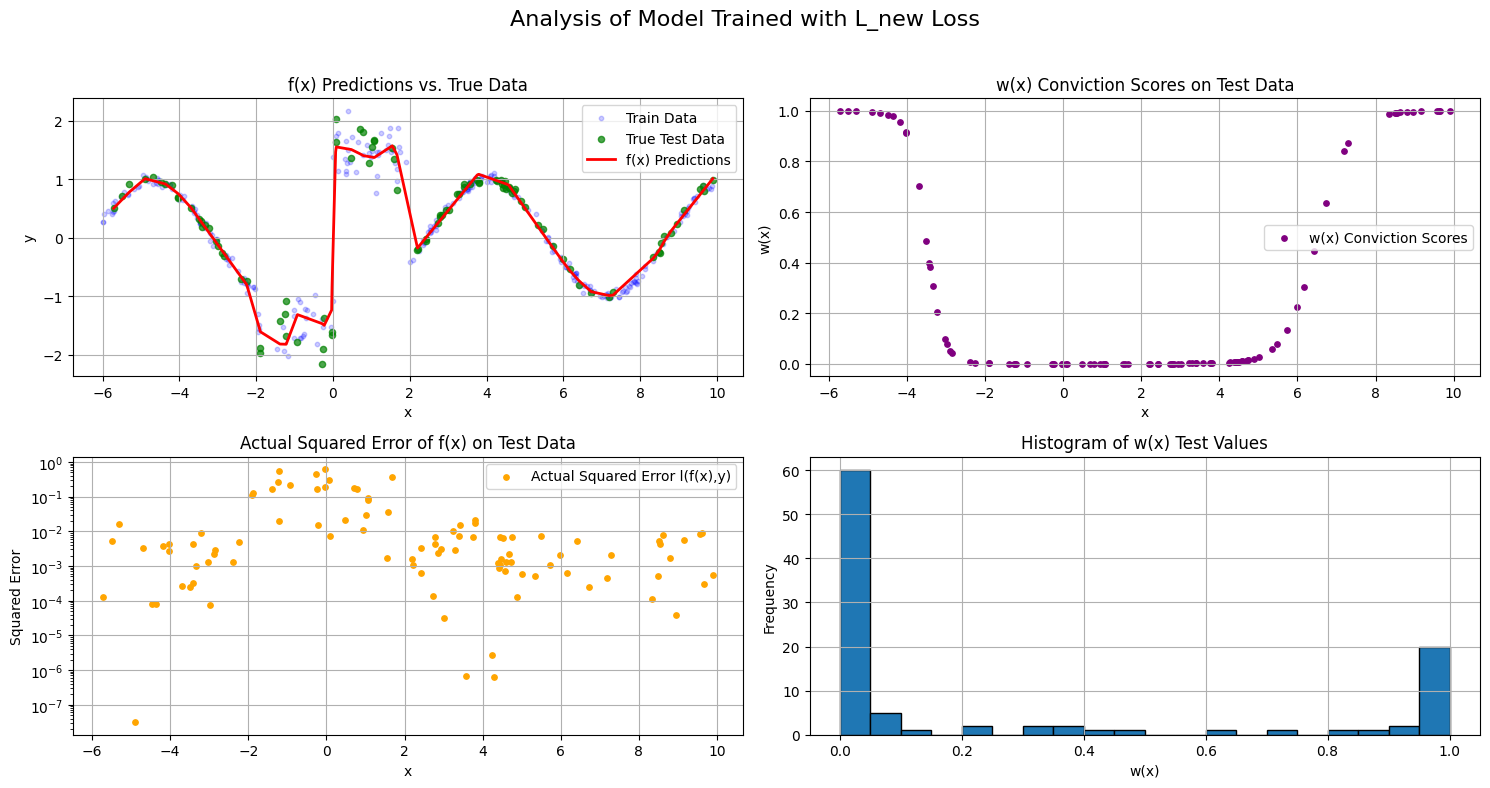

In [ ]:
# ==============================================================================
#                      SEPARATE FREEZE MODEL TRAINING & EVALUATION (Dataset V2)
# ==============================================================================
print("\n--- 4. Separate Freeze Model Training (Dataset V2) ---")
# Instantiate models
f_separate_v2, w_separate_v2 = create_networks(input_dim=1)

# Train the models using the new 'separate_freeze_w' strategy
history_separate_v2 = train_model(
    f_model=f_separate_v2,
    w_model=w_separate_v2,
    x_train=x_train_v2,
    y_train=y_train_v2,
    training_strategy='separate_freeze_w',
    epochs=EPOCHS_LNEW,
    learning_rate=LEARNING_RATE,
    device=DEVICE
)

# Evaluate the models
print("\n--- Separate Freeze Model Evaluation Results (Dataset V2) ---")
evaluation_results_separate_v2 = evaluate_model(
    f_model=f_separate_v2,
    w_model=w_separate_v2,
    x_test=x_test_v2,
    y_test=y_test_v2,
    device=DEVICE
)

# --- Visualisation for Separate Freeze model (Dataset V2) ---
if history_separate_v2 and 'epoch_loss' in history_separate_v2: # Check if w(x) history is available
     plot_L_new(history_separate_v2)

if evaluation_results_separate_v2:
    plot_xy_L_new(
        x_train=x_train_v2,
        y_train=y_train_v2,
        x_test=evaluation_results_separate_v2['x_test'],
        y_test=evaluation_results_separate_v2['y_test'],
        f_test_preds=evaluation_results_separate_v2['f_test_preds'],
        w_test_preds=evaluation_results_separate_v2['w_test_preds'],
        l_test_actual=evaluation_results_separate_v2['l_test_actual']
    )


### Insights or Next Steps

*   The positive correlation suggests that the `w(x)` model, trained with the L\_new loss, is effectively learning to predict uncertainty related to the `f(x)` model's errors.
*   The distribution of $w(x)$ values can be further analyzed to understand the model's confidence across the input range and identify areas where the model is consistently uncertain.
